In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline
#A100 80GB

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
ACANET_MODEL = ACANet_GAT

In [6]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    model = ACANET_MODEL(**pub_args, heads = 4, concat = False).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [7]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [8]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [9]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.8725 tsm_loss: 4.3223 reg_loss: 6.5502 n_pos_triplets: 223381;  Val: 6.7674 Test: 6.7880
Epoch: 002, Loss: 8.9193 tsm_loss: 2.7787 reg_loss: 6.1406 n_pos_triplets: 217173;  Val: 6.7672 Test: 6.7877
Epoch: 003, Loss: 7.8706 tsm_loss: 2.2397 reg_loss: 5.6309 n_pos_triplets: 212377;  Val: 6.7676 Test: 6.7881
Epoch: 004, Loss: 6.8736 tsm_loss: 1.9621 reg_loss: 4.9115 n_pos_triplets: 209972;  Val: 6.7669 Test: 6.7875
Epoch: 005, Loss: 5.7237 tsm_loss: 1.7950 reg_loss: 3.9288 n_pos_triplets: 205535;  Val: 6.7633 Test: 6.7839
Epoch: 006, Loss: 4.2343 tsm_loss: 1.6705 reg_loss: 2.5638 n_pos_triplets: 201661;  Val: 6.7431 Test: 6.7636
Epoch: 007, Loss: 2.6221 tsm_loss: 1.5647 reg_loss: 1.0574 n_pos_triplets: 193564;  Val: 6.4612 Test: 6.4813
Epoch: 008, Loss: 2.5539 tsm_loss: 1.4811 reg_loss: 1.0728 n_pos_triplets: 185546;  Val: 5.5921 Test: 5.6113
Epoch: 009, Loss: 2.1945 tsm_loss: 1.3774 reg_loss: 0.8172 n_pos_triplets: 185569;  Val: 4.7472 Test: 4.7651
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5427 tsm_loss: 4.6389 reg_loss: 6.5427 n_pos_triplets: 220379;  Val: 6.7840 Test: 6.8046
Epoch: 002, Loss: 6.0412 tsm_loss: 5.1162 reg_loss: 6.0412 n_pos_triplets: 219214;  Val: 6.7819 Test: 6.8025
Epoch: 003, Loss: 5.3391 tsm_loss: 5.8241 reg_loss: 5.3391 n_pos_triplets: 216387;  Val: 6.7816 Test: 6.8022
Epoch: 004, Loss: 4.2558 tsm_loss: 6.5130 reg_loss: 4.2558 n_pos_triplets: 214225;  Val: 6.7791 Test: 6.7997
Epoch: 005, Loss: 2.6011 tsm_loss: 7.0280 reg_loss: 2.6011 n_pos_triplets: 212258;  Val: 6.7747 Test: 6.7953
Epoch: 006, Loss: 1.1453 tsm_loss: 6.5852 reg_loss: 1.1453 n_pos_triplets: 210756;  Val: 6.7686 Test: 6.7891
Epoch: 007, Loss: 1.0871 tsm_loss: 5.4875 reg_loss: 1.0871 n_pos_triplets: 207129;  Val: 6.7351 Test: 6.7549
Epoch: 008, Loss: 0.8232 tsm_loss: 4.8570 reg_loss: 0.8232 n_pos_triplets: 202314;  Val: 6.4735 Test: 6.4925
Epoch: 009, Loss: 0.7456 tsm_loss: 4.5227 reg_loss: 0.7456 n_pos_triplets: 196925;  Val: 5.8722 Test: 5.8887
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.3160 tsm_loss: 3.6998 reg_loss: 6.6162 n_pos_triplets: 223380;  Val: 6.9425 Test: 6.9187
Epoch: 002, Loss: 8.5887 tsm_loss: 2.4158 reg_loss: 6.1729 n_pos_triplets: 219483;  Val: 6.9432 Test: 6.9194
Epoch: 003, Loss: 7.6499 tsm_loss: 2.0532 reg_loss: 5.5967 n_pos_triplets: 208873;  Val: 6.9442 Test: 6.9204
Epoch: 004, Loss: 6.5900 tsm_loss: 1.8165 reg_loss: 4.7734 n_pos_triplets: 200867;  Val: 6.9418 Test: 6.9180
Epoch: 005, Loss: 5.3065 tsm_loss: 1.6719 reg_loss: 3.6346 n_pos_triplets: 197676;  Val: 6.9366 Test: 6.9126
Epoch: 006, Loss: 3.5812 tsm_loss: 1.5340 reg_loss: 2.0472 n_pos_triplets: 190298;  Val: 6.9189 Test: 6.8944
Epoch: 007, Loss: 2.3405 tsm_loss: 1.4756 reg_loss: 0.8649 n_pos_triplets: 184501;  Val: 6.6337 Test: 6.6065
Epoch: 008, Loss: 2.4559 tsm_loss: 1.3778 reg_loss: 1.0780 n_pos_triplets: 176365;  Val: 5.7811 Test: 5.7525
Epoch: 009, Loss: 2.0026 tsm_loss: 1.3121 reg_loss: 0.6905 n_pos_triplets: 177841;  Val: 4.8816 Test: 4.8549
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.7901 tsm_loss: 4.1110 reg_loss: 6.7901 n_pos_triplets: 216631;  Val: 6.9369 Test: 6.9131
Epoch: 002, Loss: 6.5686 tsm_loss: 4.1370 reg_loss: 6.5686 n_pos_triplets: 217506;  Val: 6.9364 Test: 6.9126
Epoch: 003, Loss: 6.3527 tsm_loss: 4.1267 reg_loss: 6.3527 n_pos_triplets: 215622;  Val: 6.9366 Test: 6.9127
Epoch: 004, Loss: 5.9496 tsm_loss: 4.2534 reg_loss: 5.9496 n_pos_triplets: 212307;  Val: 6.9335 Test: 6.9096
Epoch: 005, Loss: 5.2621 tsm_loss: 4.3886 reg_loss: 5.2621 n_pos_triplets: 209751;  Val: 6.9294 Test: 6.9056
Epoch: 006, Loss: 4.1499 tsm_loss: 4.7534 reg_loss: 4.1499 n_pos_triplets: 206434;  Val: 6.9282 Test: 6.9044
Epoch: 007, Loss: 2.4808 tsm_loss: 4.9229 reg_loss: 2.4808 n_pos_triplets: 206984;  Val: 6.9225 Test: 6.8985
Epoch: 008, Loss: 1.0388 tsm_loss: 5.1353 reg_loss: 1.0388 n_pos_triplets: 204613;  Val: 6.8208 Test: 6.7940
Epoch: 009, Loss: 1.0737 tsm_loss: 4.8502 reg_loss: 1.0737 n_pos_triplets: 197544;  Val: 6.3590 Test: 6.3301
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.1611 tsm_loss: 3.7187 reg_loss: 6.4424 n_pos_triplets: 222947;  Val: 6.8279 Test: 6.7445
Epoch: 002, Loss: 8.6075 tsm_loss: 2.6638 reg_loss: 5.9436 n_pos_triplets: 220716;  Val: 6.8274 Test: 6.7440
Epoch: 003, Loss: 7.4369 tsm_loss: 2.2045 reg_loss: 5.2324 n_pos_triplets: 217615;  Val: 6.8256 Test: 6.7422
Epoch: 004, Loss: 6.1737 tsm_loss: 1.9578 reg_loss: 4.2159 n_pos_triplets: 213121;  Val: 6.8231 Test: 6.7398
Epoch: 005, Loss: 4.5454 tsm_loss: 1.7677 reg_loss: 2.7777 n_pos_triplets: 206328;  Val: 6.8187 Test: 6.7354
Epoch: 006, Loss: 2.7759 tsm_loss: 1.6840 reg_loss: 1.0919 n_pos_triplets: 202389;  Val: 6.8122 Test: 6.7288
Epoch: 007, Loss: 2.6343 tsm_loss: 1.5730 reg_loss: 1.0614 n_pos_triplets: 196680;  Val: 6.6503 Test: 6.5718
Epoch: 008, Loss: 2.3173 tsm_loss: 1.4495 reg_loss: 0.8677 n_pos_triplets: 195932;  Val: 5.9792 Test: 5.9102
Epoch: 009, Loss: 2.1361 tsm_loss: 1.3894 reg_loss: 0.7467 n_pos_triplets: 186128;  Val: 5.1582 Test: 5.1007
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5222 tsm_loss: 5.2225 reg_loss: 6.5222 n_pos_triplets: 218152;  Val: 6.9946 Test: 6.9113
Epoch: 002, Loss: 5.8510 tsm_loss: 5.6831 reg_loss: 5.8510 n_pos_triplets: 212542;  Val: 6.9941 Test: 6.9108
Epoch: 003, Loss: 4.8244 tsm_loss: 6.0636 reg_loss: 4.8244 n_pos_triplets: 208228;  Val: 6.9932 Test: 6.9099
Epoch: 004, Loss: 3.2568 tsm_loss: 6.8181 reg_loss: 3.2568 n_pos_triplets: 209071;  Val: 6.9921 Test: 6.9087
Epoch: 005, Loss: 1.4964 tsm_loss: 6.4170 reg_loss: 1.4964 n_pos_triplets: 211485;  Val: 6.9888 Test: 6.9055
Epoch: 006, Loss: 1.1519 tsm_loss: 4.9949 reg_loss: 1.1519 n_pos_triplets: 207585;  Val: 6.9854 Test: 6.9022
Epoch: 007, Loss: 0.8181 tsm_loss: 4.4801 reg_loss: 0.8181 n_pos_triplets: 203810;  Val: 6.8402 Test: 6.7616
Epoch: 008, Loss: 0.7510 tsm_loss: 4.2957 reg_loss: 0.7510 n_pos_triplets: 200303;  Val: 6.2466 Test: 6.1766
Epoch: 009, Loss: 0.6755 tsm_loss: 4.1011 reg_loss: 0.6755 n_pos_triplets: 196616;  Val: 5.2675 Test: 5.2080
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 9.9051 tsm_loss: 3.3420 reg_loss: 6.5632 n_pos_triplets: 223173;  Val: 6.8439 Test: 6.9128
Epoch: 002, Loss: 8.5205 tsm_loss: 2.3439 reg_loss: 6.1766 n_pos_triplets: 216528;  Val: 6.8454 Test: 6.9143
Epoch: 003, Loss: 7.5855 tsm_loss: 1.9520 reg_loss: 5.6335 n_pos_triplets: 210539;  Val: 6.8443 Test: 6.9132
Epoch: 004, Loss: 6.5863 tsm_loss: 1.7375 reg_loss: 4.8488 n_pos_triplets: 204274;  Val: 6.8415 Test: 6.9104
Epoch: 005, Loss: 5.3280 tsm_loss: 1.5796 reg_loss: 3.7484 n_pos_triplets: 198093;  Val: 6.8372 Test: 6.9061
Epoch: 006, Loss: 3.7361 tsm_loss: 1.4935 reg_loss: 2.2426 n_pos_triplets: 190994;  Val: 6.8042 Test: 6.8726
Epoch: 007, Loss: 2.3552 tsm_loss: 1.4353 reg_loss: 0.9199 n_pos_triplets: 188488;  Val: 6.3458 Test: 6.4082
Epoch: 008, Loss: 2.4089 tsm_loss: 1.3578 reg_loss: 1.0511 n_pos_triplets: 182855;  Val: 5.3970 Test: 5.4530
Epoch: 009, Loss: 2.0143 tsm_loss: 1.2642 reg_loss: 0.7501 n_pos_triplets: 180278;  Val: 4.5163 Test: 4.5641
Epoch: 010, Loss: 1

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5343 tsm_loss: 4.7368 reg_loss: 6.5343 n_pos_triplets: 226526;  Val: 6.8829 Test: 6.9517
Epoch: 002, Loss: 5.8959 tsm_loss: 5.1928 reg_loss: 5.8959 n_pos_triplets: 222460;  Val: 6.8825 Test: 6.9513
Epoch: 003, Loss: 5.0329 tsm_loss: 6.2425 reg_loss: 5.0329 n_pos_triplets: 218951;  Val: 6.8810 Test: 6.9498
Epoch: 004, Loss: 3.6450 tsm_loss: 7.5568 reg_loss: 3.6450 n_pos_triplets: 218060;  Val: 6.8806 Test: 6.9495
Epoch: 005, Loss: 1.7454 tsm_loss: 7.0367 reg_loss: 1.7454 n_pos_triplets: 215122;  Val: 6.8811 Test: 6.9499
Epoch: 006, Loss: 1.1818 tsm_loss: 4.8310 reg_loss: 1.1818 n_pos_triplets: 215955;  Val: 6.8770 Test: 6.9458
Epoch: 007, Loss: 0.8377 tsm_loss: 4.2757 reg_loss: 0.8377 n_pos_triplets: 212478;  Val: 6.8558 Test: 6.9240
Epoch: 008, Loss: 0.7631 tsm_loss: 3.8884 reg_loss: 0.7631 n_pos_triplets: 203958;  Val: 6.6079 Test: 6.6708
Epoch: 009, Loss: 0.6904 tsm_loss: 3.6738 reg_loss: 0.6904 n_pos_triplets: 195590;  Val: 5.9560 Test: 6.0111
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 9.9902 tsm_loss: 3.6917 reg_loss: 6.2985 n_pos_triplets: 222181;  Val: 6.6825 Test: 6.7348
Epoch: 002, Loss: 8.4516 tsm_loss: 2.6149 reg_loss: 5.8367 n_pos_triplets: 220111;  Val: 6.6852 Test: 6.7376
Epoch: 003, Loss: 7.4108 tsm_loss: 2.1620 reg_loss: 5.2488 n_pos_triplets: 209517;  Val: 6.6867 Test: 6.7391
Epoch: 004, Loss: 6.3488 tsm_loss: 1.9208 reg_loss: 4.4279 n_pos_triplets: 206739;  Val: 6.6849 Test: 6.7372
Epoch: 005, Loss: 4.9446 tsm_loss: 1.6919 reg_loss: 3.2527 n_pos_triplets: 197854;  Val: 6.6793 Test: 6.7315
Epoch: 006, Loss: 3.2420 tsm_loss: 1.6333 reg_loss: 1.6087 n_pos_triplets: 196547;  Val: 6.6549 Test: 6.7061
Epoch: 007, Loss: 2.4750 tsm_loss: 1.5230 reg_loss: 0.9519 n_pos_triplets: 190566;  Val: 6.3205 Test: 6.3656
Epoch: 008, Loss: 2.3537 tsm_loss: 1.4322 reg_loss: 0.9215 n_pos_triplets: 178885;  Val: 5.5862 Test: 5.6262
Epoch: 009, Loss: 2.0404 tsm_loss: 1.3127 reg_loss: 0.7277 n_pos_triplets: 179053;  Val: 4.7360 Test: 4.7743
Epoch: 010, Loss: 1

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4672 tsm_loss: 4.4654 reg_loss: 6.4672 n_pos_triplets: 219706;  Val: 6.8952 Test: 6.9478
Epoch: 002, Loss: 5.9327 tsm_loss: 4.8626 reg_loss: 5.9327 n_pos_triplets: 215381;  Val: 6.8968 Test: 6.9495
Epoch: 003, Loss: 5.1744 tsm_loss: 5.5277 reg_loss: 5.1744 n_pos_triplets: 213351;  Val: 6.8961 Test: 6.9487
Epoch: 004, Loss: 4.0016 tsm_loss: 6.3991 reg_loss: 4.0016 n_pos_triplets: 212087;  Val: 6.8941 Test: 6.9467
Epoch: 005, Loss: 2.2455 tsm_loss: 6.9860 reg_loss: 2.2455 n_pos_triplets: 212364;  Val: 6.8920 Test: 6.9446
Epoch: 006, Loss: 1.0596 tsm_loss: 5.5216 reg_loss: 1.0596 n_pos_triplets: 207444;  Val: 6.8894 Test: 6.9419
Epoch: 007, Loss: 0.9831 tsm_loss: 4.4520 reg_loss: 0.9831 n_pos_triplets: 204022;  Val: 6.8649 Test: 6.9166
Epoch: 008, Loss: 0.8236 tsm_loss: 3.9790 reg_loss: 0.8236 n_pos_triplets: 200076;  Val: 6.6998 Test: 6.7486
Epoch: 009, Loss: 0.7220 tsm_loss: 3.8463 reg_loss: 0.7220 n_pos_triplets: 191863;  Val: 6.1733 Test: 6.2144
Epoch: 010, Loss: 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 074, Loss: 0.6120 tsm_loss: 0.3479 reg_loss: 0.2641 n_pos_triplets: 90577;  Val: 0.7089 Test: 0.6489
Epoch: 075, Loss: 0.6270 tsm_loss: 0.3610 reg_loss: 0.2660 n_pos_triplets: 97880;  Val: 0.6934 Test: 0.6330
Epoch: 076, Loss: 0.6233 tsm_loss: 0.3441 reg_loss: 0.2792 n_pos_triplets: 91176;  Val: 0.7018 Test: 0.6352
Epoch: 077, Loss: 0.5935 tsm_loss: 0.3293 reg_loss: 0.2642 n_pos_triplets: 90718;  Val: 0.6884 Test: 0.6405
Epoch: 078, Loss: 0.6276 tsm_loss: 0.3338 reg_loss: 0.2938 n_pos_triplets: 92570;  Val: 0.7020 Test: 0.6524
Epoch: 079, Loss: 0.6008 tsm_loss: 0.3172 reg_loss: 0.2836 n_pos_triplets: 88364;  Val: 0.6978 Test: 0.6399
Epoch: 080, Loss: 0.6020 tsm_loss: 0.3311 reg_loss: 0.2710 n_pos_triplets: 91361;  Val: 0.6942 Test: 0.6400
Epoch: 081, Loss: 0.5909 tsm_loss: 0.3131 reg_loss: 0.2778 n_pos_triplets: 87972;  Val: 0.7054 Test: 0.6528
Epoch: 082, Loss: 0.5638 tsm_loss: 0.3163 reg_loss: 0.2475 n_pos_triplets: 87826;  Val: 0.6942 Test: 0.6409
Epoch: 083, Loss: 0.5818 tsm

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3076 tsm_loss: 4.3132 reg_loss: 6.3076 n_pos_triplets: 227899;  Val: 6.7001 Test: 6.6687
Epoch: 002, Loss: 5.8249 tsm_loss: 4.6193 reg_loss: 5.8249 n_pos_triplets: 222312;  Val: 6.6986 Test: 6.6672
Epoch: 003, Loss: 5.1023 tsm_loss: 5.2889 reg_loss: 5.1023 n_pos_triplets: 218027;  Val: 6.6975 Test: 6.6661
Epoch: 004, Loss: 3.9924 tsm_loss: 6.3319 reg_loss: 3.9924 n_pos_triplets: 213546;  Val: 6.6953 Test: 6.6639
Epoch: 005, Loss: 2.4040 tsm_loss: 6.7821 reg_loss: 2.4040 n_pos_triplets: 209883;  Val: 6.6919 Test: 6.6606
Epoch: 006, Loss: 1.1070 tsm_loss: 5.3162 reg_loss: 1.1070 n_pos_triplets: 209673;  Val: 6.6849 Test: 6.6536
Epoch: 007, Loss: 0.9588 tsm_loss: 4.3227 reg_loss: 0.9588 n_pos_triplets: 203314;  Val: 6.6199 Test: 6.5899
Epoch: 008, Loss: 0.7732 tsm_loss: 3.8878 reg_loss: 0.7732 n_pos_triplets: 199314;  Val: 6.2003 Test: 6.1749
Epoch: 009, Loss: 0.6996 tsm_loss: 3.8807 reg_loss: 0.6996 n_pos_triplets: 193813;  Val: 5.5224 Test: 5.5035
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.1563 tsm_loss: 3.6806 reg_loss: 6.4757 n_pos_triplets: 224307;  Val: 6.6235 Test: 6.6727
Epoch: 002, Loss: 8.5742 tsm_loss: 2.5051 reg_loss: 6.0691 n_pos_triplets: 220146;  Val: 6.6244 Test: 6.6736
Epoch: 003, Loss: 7.5341 tsm_loss: 1.9705 reg_loss: 5.5636 n_pos_triplets: 205843;  Val: 6.6252 Test: 6.6744
Epoch: 004, Loss: 6.5697 tsm_loss: 1.6922 reg_loss: 4.8774 n_pos_triplets: 202771;  Val: 6.6240 Test: 6.6731
Epoch: 005, Loss: 5.4305 tsm_loss: 1.5096 reg_loss: 3.9209 n_pos_triplets: 196012;  Val: 6.6215 Test: 6.6706
Epoch: 006, Loss: 4.0025 tsm_loss: 1.3978 reg_loss: 2.6047 n_pos_triplets: 188185;  Val: 6.6119 Test: 6.6610
Epoch: 007, Loss: 2.4615 tsm_loss: 1.3766 reg_loss: 1.0848 n_pos_triplets: 184565;  Val: 6.4532 Test: 6.5030
Epoch: 008, Loss: 2.2980 tsm_loss: 1.3268 reg_loss: 0.9712 n_pos_triplets: 184133;  Val: 5.7701 Test: 5.8225
Epoch: 009, Loss: 2.0576 tsm_loss: 1.2343 reg_loss: 0.8232 n_pos_triplets: 174756;  Val: 4.8583 Test: 4.9120
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4071 tsm_loss: 4.4144 reg_loss: 6.4071 n_pos_triplets: 226192;  Val: 6.6810 Test: 6.7301
Epoch: 002, Loss: 5.9640 tsm_loss: 4.2183 reg_loss: 5.9640 n_pos_triplets: 221425;  Val: 6.6815 Test: 6.7306
Epoch: 003, Loss: 5.3667 tsm_loss: 4.2326 reg_loss: 5.3667 n_pos_triplets: 217139;  Val: 6.6806 Test: 6.7296
Epoch: 004, Loss: 4.4647 tsm_loss: 4.5195 reg_loss: 4.4647 n_pos_triplets: 212778;  Val: 6.6794 Test: 6.7285
Epoch: 005, Loss: 3.0488 tsm_loss: 5.0267 reg_loss: 3.0488 n_pos_triplets: 206160;  Val: 6.6765 Test: 6.7256
Epoch: 006, Loss: 1.2775 tsm_loss: 5.3617 reg_loss: 1.2775 n_pos_triplets: 202470;  Val: 6.6732 Test: 6.7223
Epoch: 007, Loss: 1.1341 tsm_loss: 5.1020 reg_loss: 1.1341 n_pos_triplets: 193714;  Val: 6.6407 Test: 6.6893
Epoch: 008, Loss: 0.8648 tsm_loss: 4.7768 reg_loss: 0.8648 n_pos_triplets: 199305;  Val: 6.3324 Test: 6.3795
Epoch: 009, Loss: 0.7247 tsm_loss: 4.3064 reg_loss: 0.7247 n_pos_triplets: 197076;  Val: 5.7243 Test: 5.7686
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.8197 tsm_loss: 3.9398 reg_loss: 6.8799 n_pos_triplets: 226321;  Val: 6.8365 Test: 7.0598
Epoch: 002, Loss: 9.1884 tsm_loss: 2.6276 reg_loss: 6.5608 n_pos_triplets: 220185;  Val: 6.8351 Test: 7.0584
Epoch: 003, Loss: 8.3702 tsm_loss: 2.1853 reg_loss: 6.1849 n_pos_triplets: 222269;  Val: 6.8343 Test: 7.0576
Epoch: 004, Loss: 7.5103 tsm_loss: 1.8632 reg_loss: 5.6471 n_pos_triplets: 219901;  Val: 6.8322 Test: 7.0554
Epoch: 005, Loss: 6.4748 tsm_loss: 1.6446 reg_loss: 4.8303 n_pos_triplets: 212993;  Val: 6.8279 Test: 7.0512
Epoch: 006, Loss: 5.1971 tsm_loss: 1.5121 reg_loss: 3.6850 n_pos_triplets: 205380;  Val: 6.8075 Test: 7.0304
Epoch: 007, Loss: 3.5549 tsm_loss: 1.4104 reg_loss: 2.1445 n_pos_triplets: 195254;  Val: 6.5378 Test: 6.7554
Epoch: 008, Loss: 2.2420 tsm_loss: 1.3714 reg_loss: 0.8706 n_pos_triplets: 188688;  Val: 5.6244 Test: 5.8284
Epoch: 009, Loss: 2.3141 tsm_loss: 1.2796 reg_loss: 1.0345 n_pos_triplets: 181401;  Val: 4.4610 Test: 4.6474
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.7304 tsm_loss: 4.1136 reg_loss: 6.7304 n_pos_triplets: 224192;  Val: 6.7562 Test: 6.9797
Epoch: 002, Loss: 6.2432 tsm_loss: 4.0957 reg_loss: 6.2432 n_pos_triplets: 225939;  Val: 6.7560 Test: 6.9794
Epoch: 003, Loss: 5.6077 tsm_loss: 3.9918 reg_loss: 5.6077 n_pos_triplets: 220686;  Val: 6.7534 Test: 6.9769
Epoch: 004, Loss: 4.6444 tsm_loss: 4.3443 reg_loss: 4.6444 n_pos_triplets: 220102;  Val: 6.7489 Test: 6.9724
Epoch: 005, Loss: 3.2037 tsm_loss: 5.3908 reg_loss: 3.2037 n_pos_triplets: 214303;  Val: 6.7430 Test: 6.9665
Epoch: 006, Loss: 1.4842 tsm_loss: 5.8652 reg_loss: 1.4842 n_pos_triplets: 208810;  Val: 6.7360 Test: 6.9595
Epoch: 007, Loss: 1.0541 tsm_loss: 4.3772 reg_loss: 1.0541 n_pos_triplets: 207192;  Val: 6.6889 Test: 6.9105
Epoch: 008, Loss: 0.7752 tsm_loss: 3.7524 reg_loss: 0.7752 n_pos_triplets: 205902;  Val: 6.2798 Test: 6.4939
Epoch: 009, Loss: 0.7241 tsm_loss: 3.4625 reg_loss: 0.7241 n_pos_triplets: 190521;  Val: 5.4640 Test: 5.6658
Epoch: 010, Loss: 0

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 9.9870 tsm_loss: 3.6556 reg_loss: 6.3314 n_pos_triplets: 223259;  Val: 6.6853 Test: 6.7097
Epoch: 002, Loss: 8.4507 tsm_loss: 2.5260 reg_loss: 5.9248 n_pos_triplets: 217182;  Val: 6.6886 Test: 6.7130
Epoch: 003, Loss: 7.4396 tsm_loss: 2.0464 reg_loss: 5.3932 n_pos_triplets: 210444;  Val: 6.6894 Test: 6.7139
Epoch: 004, Loss: 6.4694 tsm_loss: 1.8273 reg_loss: 4.6422 n_pos_triplets: 206639;  Val: 6.6883 Test: 6.7127
Epoch: 005, Loss: 5.2620 tsm_loss: 1.6301 reg_loss: 3.6319 n_pos_triplets: 198889;  Val: 6.6835 Test: 6.7079
Epoch: 006, Loss: 3.7399 tsm_loss: 1.5521 reg_loss: 2.1878 n_pos_triplets: 193218;  Val: 6.6691 Test: 6.6936
Epoch: 007, Loss: 2.3050 tsm_loss: 1.4276 reg_loss: 0.8773 n_pos_triplets: 185581;  Val: 6.3905 Test: 6.4162
Epoch: 008, Loss: 2.3276 tsm_loss: 1.3008 reg_loss: 1.0267 n_pos_triplets: 177364;  Val: 5.5532 Test: 5.5812
Epoch: 009, Loss: 2.0196 tsm_loss: 1.2773 reg_loss: 0.7423 n_pos_triplets: 177999;  Val: 4.6335 Test: 4.6662
Epoch: 010, Loss: 1

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5686 tsm_loss: 4.4076 reg_loss: 6.5686 n_pos_triplets: 223020;  Val: 6.9443 Test: 6.9687
Epoch: 002, Loss: 6.0593 tsm_loss: 4.6536 reg_loss: 6.0593 n_pos_triplets: 219786;  Val: 6.9476 Test: 6.9719
Epoch: 003, Loss: 5.2192 tsm_loss: 4.9379 reg_loss: 5.2192 n_pos_triplets: 216164;  Val: 6.9525 Test: 6.9769
Epoch: 004, Loss: 3.8433 tsm_loss: 5.6677 reg_loss: 3.8433 n_pos_triplets: 213056;  Val: 6.9533 Test: 6.9776
Epoch: 005, Loss: 1.8516 tsm_loss: 6.1759 reg_loss: 1.8516 n_pos_triplets: 209420;  Val: 6.9497 Test: 6.9740
Epoch: 006, Loss: 1.1539 tsm_loss: 4.6541 reg_loss: 1.1539 n_pos_triplets: 205692;  Val: 6.9408 Test: 6.9650
Epoch: 007, Loss: 0.8530 tsm_loss: 4.0370 reg_loss: 0.8530 n_pos_triplets: 203034;  Val: 6.8380 Test: 6.8598
Epoch: 008, Loss: 0.8731 tsm_loss: 3.8305 reg_loss: 0.8731 n_pos_triplets: 197750;  Val: 6.5041 Test: 6.5215
Epoch: 009, Loss: 0.6948 tsm_loss: 3.9403 reg_loss: 0.6948 n_pos_triplets: 190865;  Val: 5.8855 Test: 5.9004
Epoch: 010, Loss: 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [11]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

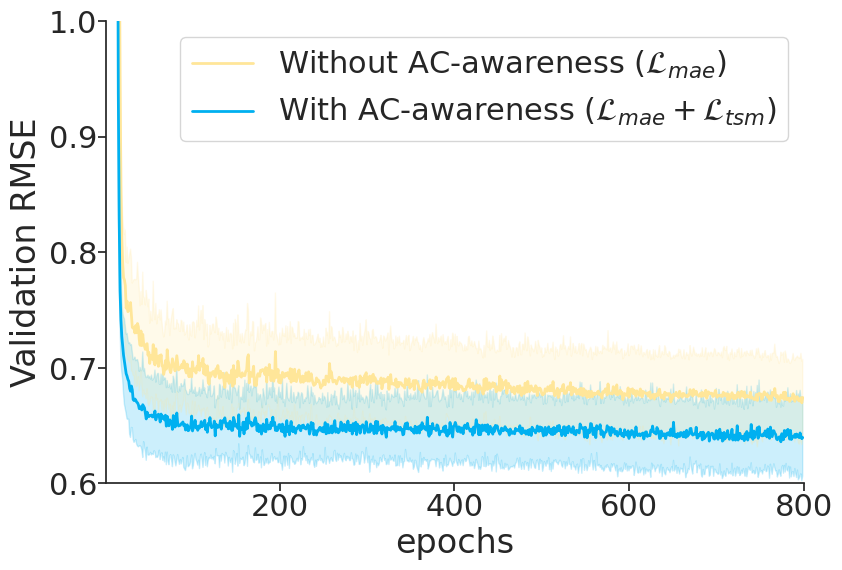

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

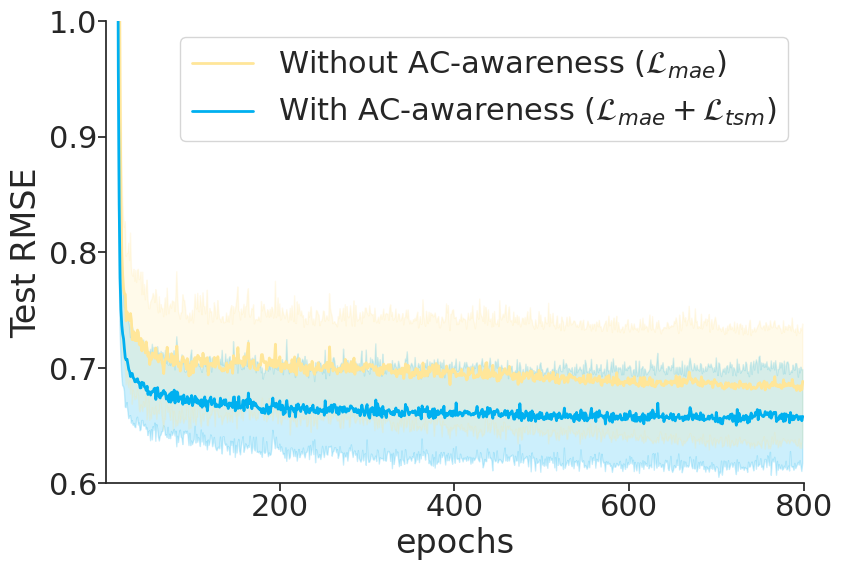

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

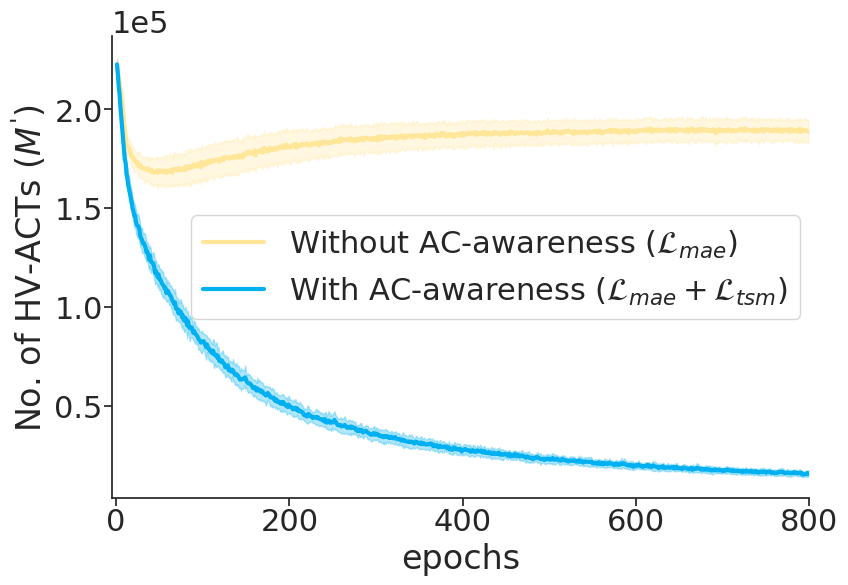

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

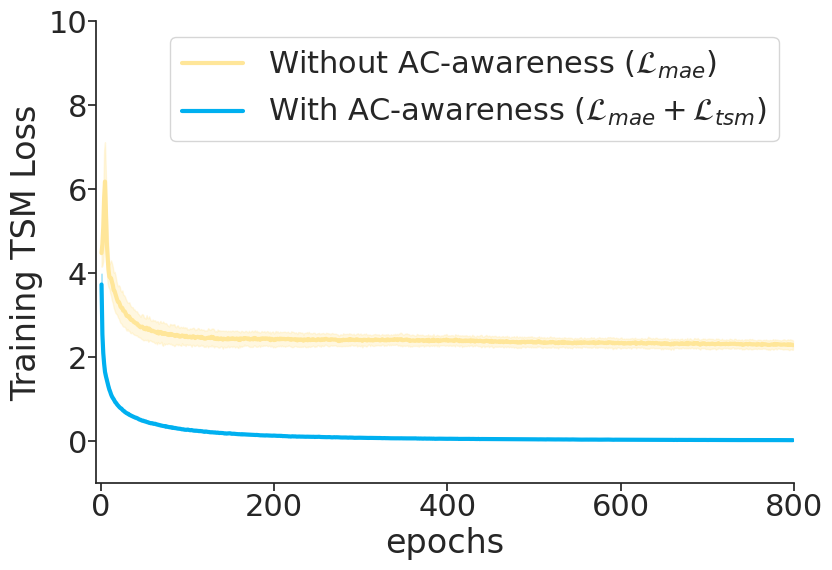

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

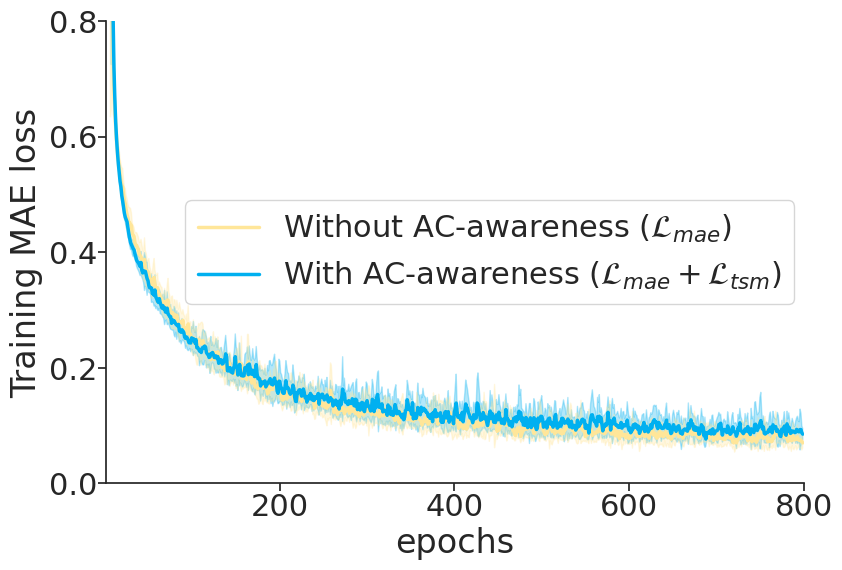

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 